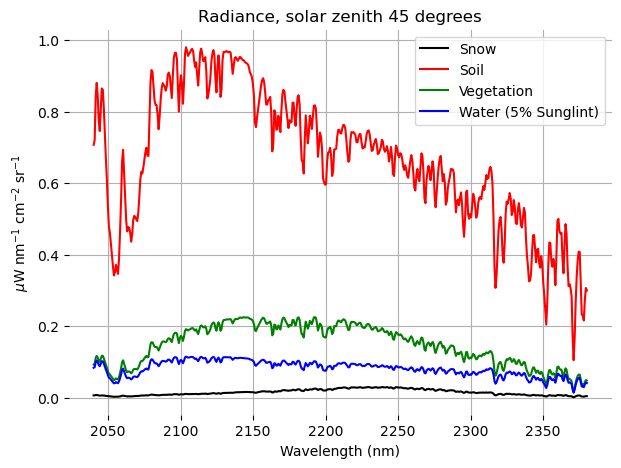

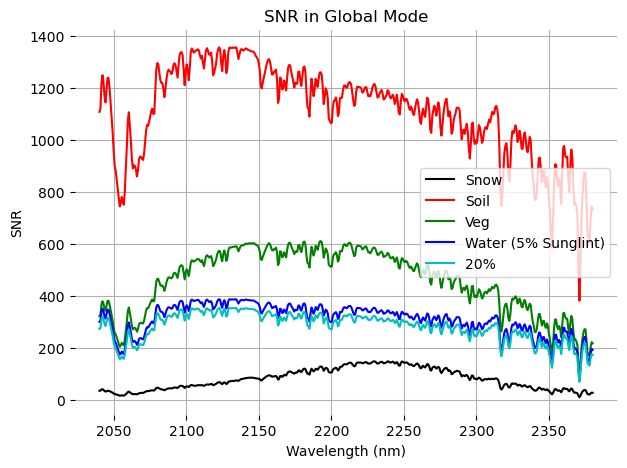

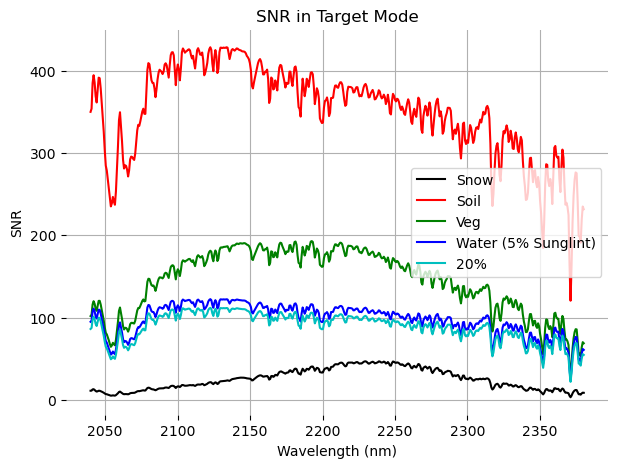

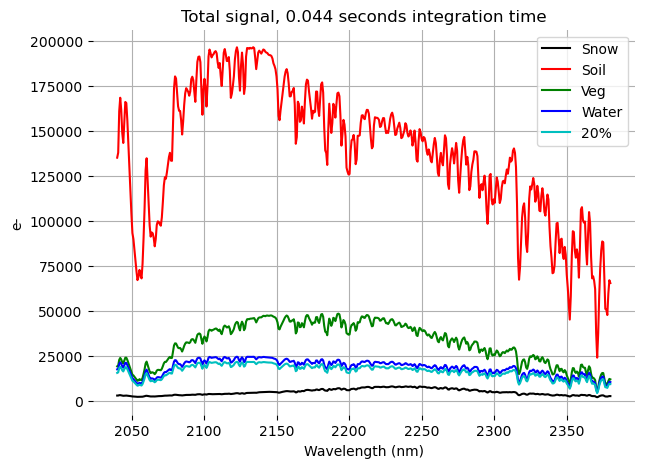

In [6]:
# Import dependencies requires installation of the isofit repository
import sys
import numpy as np
from scipy.interpolate import interp1d
from sbg_utils import load_chn, rule_07, blackbody, local_fit
import instrument
import pylab as plt

# Load MODTRAN 6.0 precalculated coefficients
# Wavelength, irradiance, path reflectance, atmospheric 
# transmittance, spherical albedo, and upward transmittance
# Solar zenith angle at 23.4 degrees 
coszen = np.cos(45/360*np.pi*2.0)
m6file = 'data/modtran/loci.chn'
wl, irr, rhoatm, transm, sphalb, tup = load_chn(m6file, coszen)

# Load instrument wavelength grid
q, wl, fwhm = np.loadtxt('data/wavelengths.txt').T * 1000.0

# Load CBE Instrument mdel
cbe = instrument.Instrument('config/loci_cbe.json')

# Calculate reference radiance of 20% reflectance
rfl_20 = np.ones(len(wl)) * 0.05#0.2
rhotoa_20 = rhoatm + transm * rfl_20 / (1.0 - sphalb * rfl_20)
rdn_20 = rhotoa_20 / np.pi * (irr * coszen)

# Calculate water case
wla, rfl_water = np.loadtxt('data/spectra/WLD_0402_S5.txt').T
rfl_water = interp1d(wla, rfl_water, fill_value='extrapolate', bounds_error=False)(wl)
rfl_water = rfl_water + 0.05 # add 5% glint
rhotoa_water = rhoatm + transm * rfl_water / (1.0 - sphalb * rfl_water)
rdn_water = rhotoa_water / np.pi * (irr * coszen)

# Calculate veg case
wla, rfl_veg = np.loadtxt('data/spectra/lawn_insitu.txt').T
rfl_veg = interp1d(wla, rfl_veg, fill_value='extrapolate', bounds_error=False)(wl)
rhotoa_veg = rhoatm + transm * rfl_veg / (1.0 - sphalb * rfl_veg)
rdn_veg = rhotoa_veg / np.pi * (irr * coszen)

# Calculate mineral case
wla = np.loadtxt('data/spectra/splib07a_Wavelengths_BECK_Beckman_0.2-3.0_microns.txt',skiprows=1) * 1000.0
rfl_mineral = np.loadtxt('data/spectra/splib07a_Montmorillonite-Na_CU93-52A_BECKc_AREF.txt',skiprows=1)
rfl_mineral = interp1d(wla, rfl_mineral, fill_value='extrapolate', bounds_error=False)(wl)
rhotoa_mineral = rhoatm + transm * rfl_mineral / (1.0 - sphalb * rfl_mineral)
rdn_mineral = rhotoa_mineral / np.pi * (irr * coszen)

# Calculate snow case
wla = np.loadtxt('data/spectra/splib07a_Wavelengths_ASD_0.35-2.5_microns_2151_ch.txt',skiprows=1) * 1000.0
rfl_snow = np.loadtxt('data/spectra/splib07a_Melting_snow_mSnw01a_ASDFRa_AREF.txt',skiprows=0)
rfl_snow = interp1d(wla, rfl_snow, fill_value='extrapolate', bounds_error=False)(wl)
rhotoa_snow = rhoatm + transm * rfl_snow / (1.0 - sphalb * rfl_snow)
rdn_snow = rhotoa_snow / np.pi * (irr * coszen)


# Plot SNR
plt.figure(figsize=(7,5))
plt.title('Radiance, solar zenith 45 degrees')
plt.plot(wl, rdn_snow,'k')
plt.plot(wl, rdn_mineral,'r')
plt.plot(wl, rdn_veg,'g')
plt.plot(wl, rdn_water,'b')
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\mu$W nm$^{-1}$ cm$^{-2}$ sr$^{-1}$ ')
plt.legend(('Snow','Soil','Vegetation','Water (5% Sunglint)','20%'))
plt.box(False)
plt.grid(True)

np.savetxt('20230714_CarbonI_Radiance_uWnm-1sr-1cm-2.txt',
          np.c_[wl,(rdn_snow),
                   (rdn_mineral),
                   (rdn_veg),
                   (rdn_water),
                   (rdn_20)],
          fmt='%f', delimiter=',',
          header='wavelength, snow, mineral, vegetation, water- 5% glint, 25% reflectance')
plt.savefig('20230714_CarbonI_Radiances.pdf')

coadd = 10 # Extra spatial coadding (not used)
plt.figure(figsize=(7,5))
plt.title('SNR in Global Mode')
plt.plot(wl, cbe.snr(rdn_snow)*np.sqrt(coadd),'k')
plt.plot(wl, cbe.snr(rdn_mineral)*np.sqrt(coadd),'r')
plt.plot(wl, cbe.snr(rdn_veg)*np.sqrt(coadd),'g')
plt.plot(wl, cbe.snr(rdn_water)*np.sqrt(coadd),'b')
plt.plot(wl, cbe.snr(rdn_20)*np.sqrt(coadd),'c')
plt.xlabel('Wavelength (nm)')
plt.ylabel('SNR')
plt.legend(('Snow','Soil','Veg','Water (5% Sunglint)','20%'))
plt.box(False)
plt.grid(True)
np.savetxt('20230714_CarbonI_SNRGlobalMode.txt',
          np.c_[wl,cbe.snr(rdn_snow),
                   cbe.snr(rdn_mineral),
                   cbe.snr(rdn_veg),
                   cbe.snr(rdn_water),
                   cbe.snr(rdn_20)],
          fmt='%f', delimiter=',',
          header='wavelength, snow, mineral, vegetation, water- 5% glint, 20% reflectance')
plt.savefig('20230714_CarbonI_SNRGlobalMode.pdf')

coadd = 1 # Extra spatial coadding (not used)
plt.figure(figsize=(7,5))
plt.title('SNR in Target Mode')
plt.plot(wl, cbe.snr(rdn_snow)*np.sqrt(coadd),'k')
plt.plot(wl, cbe.snr(rdn_mineral)*np.sqrt(coadd),'r')
plt.plot(wl, cbe.snr(rdn_veg)*np.sqrt(coadd),'g')
plt.plot(wl, cbe.snr(rdn_water)*np.sqrt(coadd),'b')
plt.plot(wl, cbe.snr(rdn_20)*np.sqrt(coadd),'c')
plt.xlabel('Wavelength (nm)')
plt.ylabel('SNR')
plt.legend(('Snow','Soil','Veg','Water (5% Sunglint)','20%'))
plt.box(False)
plt.grid(True)
np.savetxt('20230714_CarbonI_SNRTargetMode.txt',
          np.c_[wl,cbe.snr(rdn_snow),
                   cbe.snr(rdn_mineral),
                   cbe.snr(rdn_veg),
                   cbe.snr(rdn_water),
                   cbe.snr(rdn_20)],
          fmt='%f', delimiter=',',
          header='wavelength, snow, mineral, vegetation, water- 5% glint, 20% reflectance')
plt.savefig('20230714_CarbonI_SNRTargetMode.pdf')

plt.figure(figsize=(7,5))
plt.title('Total signal, %5.3f seconds integration time'%cbe.t_intp)
plt
plt.plot(wl, cbe.total_signal(rdn_snow),'k')
plt.plot(wl, cbe.total_signal(rdn_mineral),'r')
plt.plot(wl, cbe.total_signal(rdn_veg),'g')
plt.plot(wl, cbe.total_signal(rdn_water),'b')
plt.plot(wl, cbe.total_signal(rdn_20),'c')
plt.xlabel('Wavelength (nm)')
plt.ylabel('e-')
plt.legend(('Snow','Soil','Veg','Water','20%'))
plt.box(False)
plt.grid(True)
plt.savefig('20230714_CarbonI_TotalSignal.pdf')


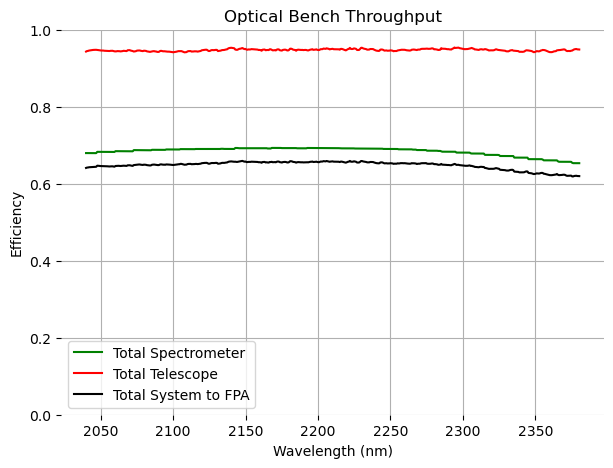

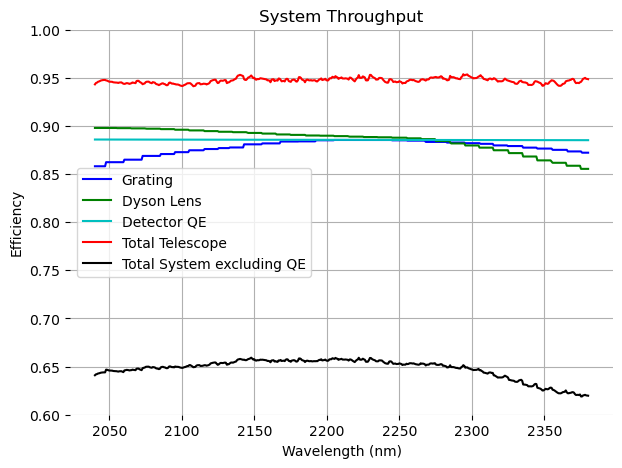

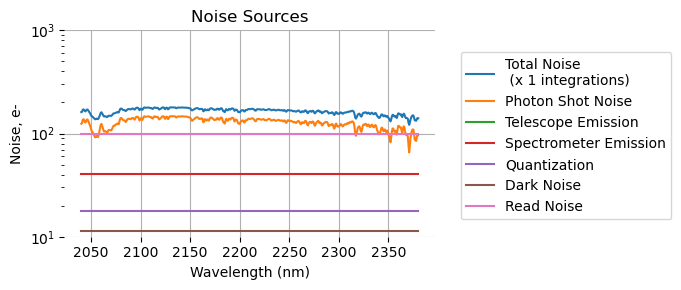

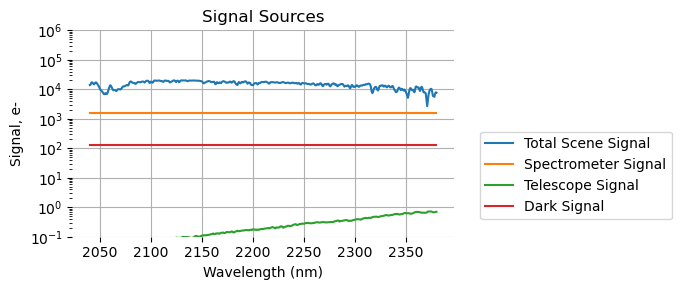

In [7]:
# Plot system efficiency
plt.figure(figsize=(7,5))
plt.plot(wl, cbe.spectrometer_transm,'g')
plt.plot(wl, cbe.telescope_transm,'r')

plt.plot(wl, cbe.efficiency()/cbe.qe,'k')

# Text annotations
plt.legend(('Total Spectrometer', 'Total Telescope', 'Total System to FPA'))
plt.title('Optical Bench Throughput')
plt.ylabel('Efficiency')
plt.xlabel('Wavelength (nm)')
plt.ylim([0, 1]);
plt.box(False)
plt.grid(True)
plt.savefig('20230714_CarbonI_OpticalBenchThroughput.pdf')
np.savetxt('20230714_CarbonI_OpticalBenchEfficiency.txt',
          np.c_[wl,cbe.efficiency()/cbe.qe], fmt='%10.8f')

plt.figure(figsize=(7,5))

plt.plot(wl, cbe.grating,'b')
plt.plot(wl, cbe.dyson_block,'g')
plt.plot(wl, cbe.qe,'c')
plt.plot(wl, cbe.telescope_transm,'r')
plt.plot(wl, cbe.efficiency()/cbe.qe,'k')

# Text annotations
plt.legend(('Grating','Dyson Lens', 'Detector QE', 'Total Telescope', 'Total System excluding QE'))
plt.title('System Throughput')
plt.ylabel('Efficiency')
plt.xlabel('Wavelength (nm)')
plt.ylim([0.6, 1]);
plt.box(False)
plt.grid(True)
plt.savefig('20230714_CarbonI_TotalThroughput.pdf')

# Plot noise sources
plt.figure(figsize=(7,3))
plt.semilogy(wl, cbe.total_noise(rdn_20))
plt.semilogy(wl, cbe.shot_noise(rdn_20))
plt.semilogy(wl, cbe.telescope_noise())
plt.semilogy(wl, cbe.spectrometer_noise())
plt.semilogy(wl, np.ones(wl.shape) * cbe.quantization_noise())
plt.semilogy(wl, np.ones(wl.shape) * cbe.dark_noise())
plt.semilogy(wl, np.ones(wl.shape) * cbe.read_noise)

# Text annotations
plt.legend(('Total Noise\n (x %d integrations)'% cbe.number_of_reads, 
            'Photon Shot Noise',
            'Telescope Emission', 'Spectrometer Emission',  'Quantization', 'Dark Noise', 'Read Noise'),
          bbox_to_anchor=(1.05, 0.05), loc='lower left')

plt.ylabel('Noise, e-')
plt.xlabel('Wavelength (nm)')
plt.title('Noise Sources')
plt.ylim([10, 1000]);
plt.box(False)
plt.grid(True)
plt.tight_layout()
plt.savefig('20230717_CarbonI_Noise.pdf')

# Plot signals sources
plt.figure(figsize=(7,3))
plt.semilogy(wl, cbe.scene_signal(rdn_20))
plt.semilogy(wl, cbe.spectrometer_signal())
plt.semilogy(wl, cbe.telescope_signal())
plt.semilogy(wl, np.ones_like(wl)*cbe.dark_signal())

# Text annotations
plt.legend(('Total Scene Signal', 
            'Spectrometer Signal',
            'Telescope Signal', 'Dark Signal'),
          bbox_to_anchor=(1.05, 0.05), loc='lower left')

plt.ylabel('Signal, e-')
plt.xlabel('Wavelength (nm)')
plt.title('Signal Sources')
plt.ylim([0.1, 1000000]);
plt.box(False)
plt.grid(True)
plt.tight_layout()
plt.savefig('20230717_CarbonI_Signal.pdf')

263.0824937406911

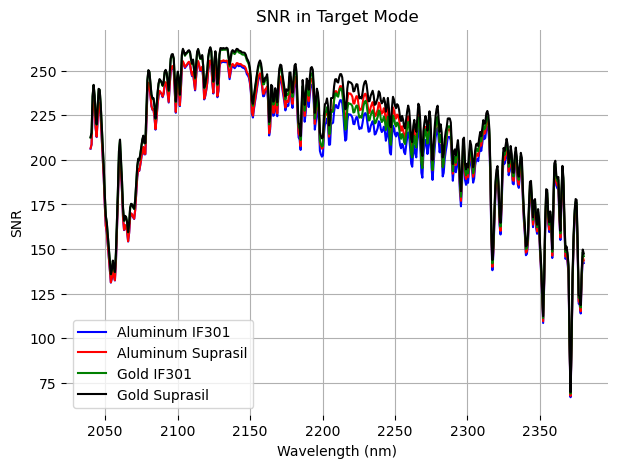

In [3]:
cbe_AlIF301 = instrument.Instrument('config/loci_cbe_20240826_AlIF301.json')
cbe_AlSuprasil = instrument.Instrument('config/loci_cbe_20240826_AlSuprasil.json')
cbe_AuIF301 = instrument.Instrument('config/loci_cbe_20240826_AuIF301.json')
cbe_AuSuprasil = instrument.Instrument('config/loci_cbe_20240826_AuSuprasil.json')


coadd = 1 # Extra spatial coadding (not used)
plt.figure(figsize=(7,5))
plt.title('SNR in Target Mode')

plt.plot(wl, cbe_AlIF301.snr(rdn_20)*np.sqrt(coadd),'b')
plt.plot(wl, cbe_AlSuprasil.snr(rdn_20)*np.sqrt(coadd),'r')
plt.plot(wl, cbe_AuIF301.snr(rdn_20)*np.sqrt(coadd),'g')
plt.plot(wl, cbe_AuSuprasil.snr(rdn_20)*np.sqrt(coadd),'k')
plt.xlabel('Wavelength (nm)')
plt.ylabel('SNR')
plt.legend(('Aluminum IF301','Aluminum Suprasil','Gold IF301','Gold Suprasil'))
plt.box(False)
plt.grid(True)
np.savetxt('20240826_CarbonI_SNRTargetMode_Trade.txt',
          np.c_[wl,cbe_AlIF301.snr(rdn_20),
                   cbe_AlSuprasil.snr(rdn_20),
                   cbe_AuIF301.snr(rdn_20),
                   cbe_AuSuprasil.snr(rdn_20)],
          fmt='%f', delimiter=',',
          header='Al-IF301, Al-Suprasil3001, Au-IF301, Au-Suprasil3001')
plt.savefig('20240826_CarbonI_SNRTargetMode_Trade.pdf')
max(cbe_AuSuprasil.snr(rdn_20))#/200.0

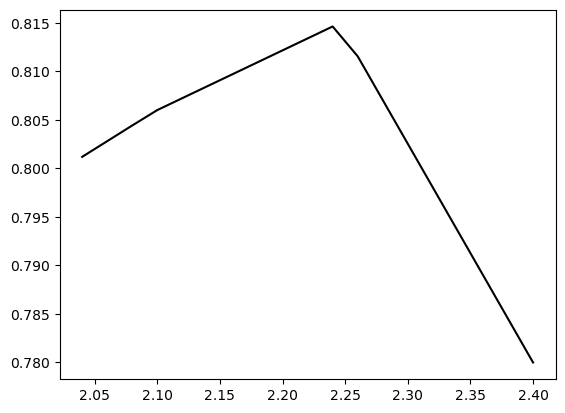

In [9]:
wlx, qe = np.loadtxt('CPM_listQE20231103.txt').T
trunc = qe[wlx<2250]
trunc_wl = wlx[wlx<2250]
augmented_wl = np.r_[trunc_wl,2400]
augmented = np.r_[trunc,0.78]
wl_new = np.arange(2040,2420,20)
new = interp1d(augmented_wl,augmented)(wl_new)
np.savetxt('CarbonI_QE.txt',np.c_[wl_new/1000.0,new],fmt='%8.6f')
plt.plot(wl_new/1000.0,new,'k')


In [1]:
import numpy as np
np.cos(45/360*2*np.pi)

0.7071067811865476

In [1]:
plt.plot(rdn)

NameError: name 'plt' is not defined